Notatnik wykonany na podstawie dokumentacji Pytorch https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

CIFAR10 has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

Load and normalize CIFAR10:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. Transform them to Tensors of normalized range [-1, 1]:

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # numbers in arguments are the means and standard devciations

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|████████████████████████| 170498071/170498071 [00:47<00:00, 3560928.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Show some of the training images:

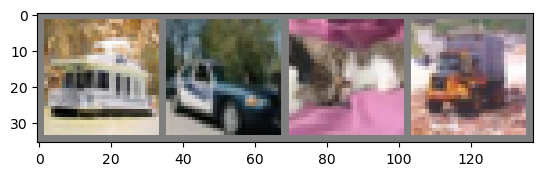

ship  car   cat   truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # Matplotlib's imshow function expects images in the format (H, W, C), so reorder the dimensions of the array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Define a Convolutional Neural Network:

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module): # nn.Module is a base class for all neural network modules in PyTorch
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # creates convolutional layer with 3 input, 6 output channels, and kernel size of 5
        self.pool = nn.MaxPool2d(2, 2) # uses a 2x2 square to pool the maximum values, pooling window moves 2 pixels 
        self.conv2 = nn.Conv2d(6, 16, 5) # 16 * 5 * 5 comes from the output dimensions of the last layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 output classes

    def forward(self, x): # x is the input tensor that flows through the network
        x = self.pool(F.relu(self.conv1(x))) # use ReLU activation function
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Define a Loss function and optimizer:

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # combining nn.LogSoftmax() to count probabilities and nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Train the network:

In [15]:
for epoch in range(5):  # loop over the dataset multiple times, 2 epochs

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # iterating over trainloader
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # the gradients accumulated from the previous batch need to be zeroed out
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.303
[1,  4000] loss: 1.317
[1,  6000] loss: 1.305
[1,  8000] loss: 1.310
[1, 10000] loss: 1.285
[1, 12000] loss: 1.305
[2,  2000] loss: 1.309
[2,  4000] loss: 1.304
[2,  6000] loss: 1.293
[2,  8000] loss: 1.325
[2, 10000] loss: 1.312
[2, 12000] loss: 1.292
[3,  2000] loss: 1.295
[3,  4000] loss: 1.289
[3,  6000] loss: 1.304
[3,  8000] loss: 1.316
[3, 10000] loss: 1.311
[3, 12000] loss: 1.300
[4,  2000] loss: 1.303
[4,  4000] loss: 1.301
[4,  6000] loss: 1.297
[4,  8000] loss: 1.306
[4, 10000] loss: 1.297
[4, 12000] loss: 1.312
[5,  2000] loss: 1.307
[5,  4000] loss: 1.296
[5,  6000] loss: 1.316
[5,  8000] loss: 1.302
[5, 10000] loss: 1.303
[5, 12000] loss: 1.302
Finished Training


To quickly save the trained model:

In [16]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Test the network on the test data:

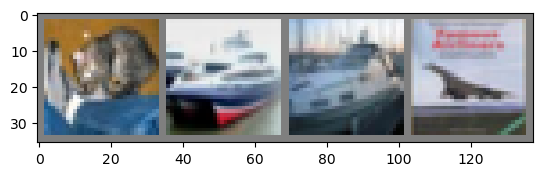

GroundTruth:  cat   ship  ship  plane


In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

To load back in saved model and predict the labels:

In [18]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
outputs = net(images)

In [20]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


Test how the network performs on the whole dataset:

In [21]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 51 %


Establish the classes that performed well, and the classes that did not perform well:

In [22]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 53.5 %
Accuracy for class: car   is 51.9 %
Accuracy for class: bird  is 33.9 %
Accuracy for class: cat   is 29.0 %
Accuracy for class: deer  is 56.4 %
Accuracy for class: dog   is 37.9 %
Accuracy for class: frog  is 79.0 %
Accuracy for class: horse is 52.0 %
Accuracy for class: ship  is 60.2 %
Accuracy for class: truck is 64.9 %


Training on GPU:

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [ ]:
net.to(device)

Then it is necessary to send the inputs and targets at every step to the GPU too:

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)